## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px;">Setup</p>

In [1]:
import os

if not os.path.isdir('src'):
    !git init .
    !git remote add origin https://github.com/Manuel-Materazzo/Mental-Health.git

print('Pulling...')
!git pull origin master -q

print('Installing dependencies...')
!pip install -r /kaggle/working/src/requirements.txt -q

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame

from src.enums.accuracy_metric import AccuracyMetric

from src.models.xgb_classifier import XGBClassifierWrapper

from src.trainers.cached_accurate_cross_trainer import CachedAccurateCrossTrainer

pd.set_option('display.max_columns', None)

def load_data():
    # Load the data
    file_path = '/kaggle/input/playground-series-s4e11/train.csv'
    data = pd.read_csv(file_path, index_col='id')

    # Remove rows with missing target, separate target from predictors
    data.dropna(axis=0, subset=['Depression'], inplace=True)
    y = data['Depression']
    X = data.drop(['Depression'], axis=1)

    # standardize column names
    data = data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
    X = X.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
    return X, y, data

print('Loading data...')
X, y, raw_data = load_data()
print('Done ✅')

Initialized empty Git repository in /kaggle/working/.git/
Pulling...
Installing dependencies...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.1 requires botocore<1.35.24,>=1.35.16, but you have botocore 1.35.85 which is incompatible.
albucore 0.0.17 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.17 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 17.0.0 which is incompatible.
bayesian-optimization 1.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
beatrix-jupyterlab 2024.66.154055 req

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Data Exploration</p>

In [2]:
raw_data.head()

,Name,Gender,Age,City,Working_Professional_or_Student,Profession,Academic_Pressure,Work_Pressure,CGPA,Study_Satisfaction,Job_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Have_you_ever_had_suicidal_thoughts_,Work_Study_Hours,Financial_Stress,Family_History_of_Mental_Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [3]:
# fast insights
print(f"There are {sum(raw_data.duplicated())} duplicated rows in the train data frame.")

print('total columns: ', len(raw_data.columns.values))

features_with_missing_values = [col for col in raw_data.columns if raw_data[col].isnull().any()]

print('number of columns with missing values: ', len(features_with_missing_values))
print(features_with_missing_values)
print('--- Percentage of Missing Values ---')
print(100*raw_data[features_with_missing_values].isnull().sum() / raw_data.shape[0])

There are 0 duplicated rows in the train data frame.
total columns:  19
number of columns with missing values:  9
['Profession', 'Academic_Pressure', 'Work_Pressure', 'CGPA', 'Study_Satisfaction', 'Job_Satisfaction', 'Dietary_Habits', 'Degree', 'Financial_Stress']
--- Percentage of Missing Values ---
Profession            26.034115
Academic_Pressure     80.172708
Work_Pressure         19.842217
CGPA                  80.171997
Study_Satisfaction    80.172708
Job_Satisfaction      19.836532
Dietary_Habits         0.002843
Degree                 0.001421
Financial_Stress       0.002843
dtype: float64


<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">
    
##### Initial observations:
* each line identifies a different person, so there is no column that correlates individual records to form a time serie.
* name and city columns **will** confuse the model, it's higly unlikely that there is any real correlation between these columns and being depressed.
* "Working_Professional_or_Student" is a boolean, and it's correlated to "Profession" (Student = NaN)
* "Work_Study_Hours" is the only column based on what they do where students and professionals have a shared value.
* "Work_Pressure" and "Academic_Pressure" could be reduced in a more generic feature "Pressure", or just 0filled on missing values.
* "Work_Satisfaction" and "Academic_Satisfaction" could be reduced in a more generic feature "Satisfaction", or just 0filled on missing values.

number of missing values on the combined "pressure" column:  21


Text(0, 0.5, 'Missing values')

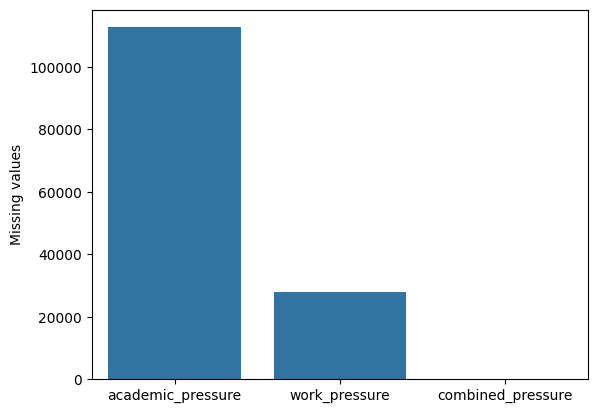

In [4]:
academic_pressure_missing_values = raw_data.loc[raw_data.Academic_Pressure.isnull()]
work_pressure_missing_values = raw_data.loc[raw_data.Work_Pressure.isnull()]
pressure_missing_values = raw_data.loc[raw_data.Academic_Pressure.isnull() & raw_data.Work_Pressure.isnull()]

print('number of missing values on the combined "pressure" column: ', len(pressure_missing_values))

sns.barplot(
    x=["academic_pressure", "work_pressure", "combined_pressure"], 
    y=[len(academic_pressure_missing_values), len(work_pressure_missing_values), len(pressure_missing_values)]
)
plt.ylabel("Missing values")

number of missing values on the combined "satisfaction" column:  15


Text(0, 0.5, 'Missing values')

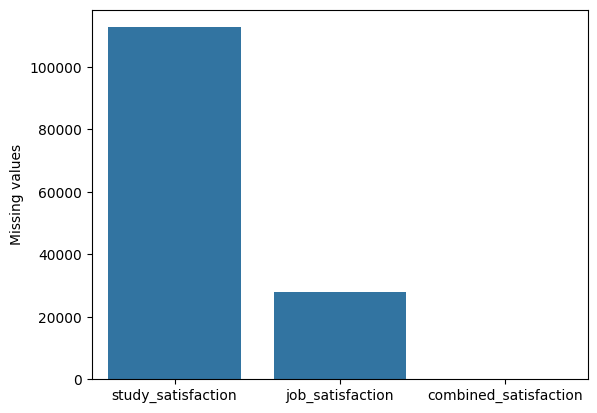

In [5]:
study_satisfaction_missing_values = raw_data.loc[raw_data.Study_Satisfaction.isnull()]
job_satisfaction_missing_values = raw_data.loc[raw_data.Job_Satisfaction.isnull()]
satisfaction_missing_values = raw_data.loc[raw_data.Study_Satisfaction.isnull() & raw_data.Job_Satisfaction.isnull()]
print('number of missing values on the combined "satisfaction" column: ', len(satisfaction_missing_values))

sns.barplot(
    x=["study_satisfaction", "job_satisfaction", "combined_satisfaction"], 
    y=[len(study_satisfaction_missing_values), len(job_satisfaction_missing_values), len(satisfaction_missing_values)]
)
plt.ylabel("Missing values")

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

By joining "satisfaction" and "pressure" columns, we could greatlty reduce the number of missing values.<br>
Being a 1 to 5 scale, remaining missing data could be filled with a "neutral" score of 3.

number of missing professions:  36630
number of missing profession when the person is not a student:  8763
number of students with a profession:  34


([<matplotlib.patches.Wedge at 0x7a3eaf2b3b20>,
 [Text(-0.8036844461683476, 0.7510601247483962, 'students without profession'),
  Text(0.8036845516473256, -0.7510600118788361, 'professionals without profession')],
 [Text(-0.43837333427364406, 0.4096691589536707, '76%'),
  Text(0.4383733918076321, -0.40966909738845597, '24%')])

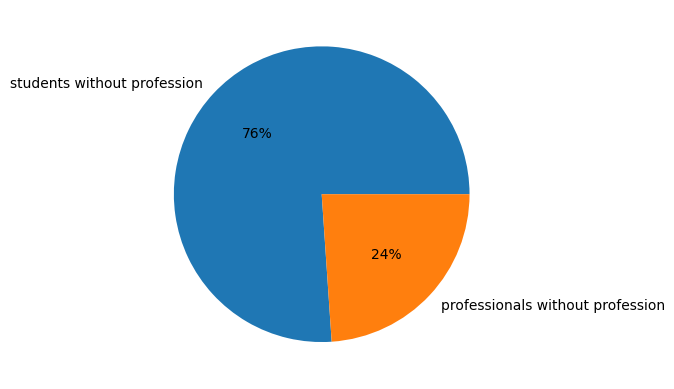

In [6]:
profession_missing_values = len(raw_data.loc[raw_data.Profession.isnull()])
profession_missing_values_students = len(raw_data.loc[raw_data.Profession.isnull() & (raw_data.Working_Professional_or_Student == 'Student')])
profession_missing_values_not_students = len(raw_data.loc[raw_data.Profession.isnull() & (raw_data.Working_Professional_or_Student == 'Working Professional')])
profession_provided_on_students = len(raw_data.loc[raw_data.Profession.notnull() & (raw_data.Working_Professional_or_Student == 'Student')])

print('number of missing professions: ', profession_missing_values)
print('number of missing profession when the person is not a student: ', profession_missing_values_not_students)
print('number of students with a profession: ', profession_provided_on_students)

plt.pie(
[
    profession_missing_values_students*100/profession_missing_values, 
    profession_missing_values_not_students*100/profession_missing_values
], 
labels = ["students without profession", "professionals without profession"], 
autopct='%.0f%%'
)

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

76% of missing profession values come from students that do not work.

number of missing cgpa:  112802
number of students with missing cgpa:  9
number of professionals with missing cgpa:  112793
number of professionals with cgpa:  6


([<matplotlib.patches.Wedge at 0x7a3eaf112800>,
 [Text(1.0999999654447683, 0.00027571998252839334, 'students without CGPA'),
  Text(-1.0999999654662498, -0.00027563426696066383, 'professionals without CGPA')],
 [Text(0.5999999811516917, 0.00015039271774276, '0%'),
  Text(-0.5999999811634089, -0.0001503459637967257, '100%')])

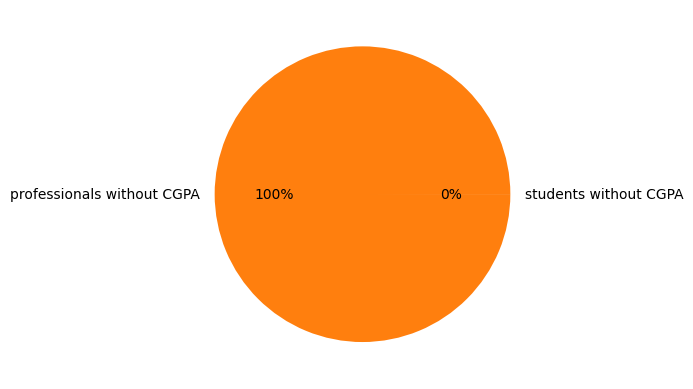

In [7]:
cgpa_missing_values = len(raw_data.loc[raw_data.CGPA.isnull()])
cgpa_students_missing_values = len(raw_data.loc[raw_data.CGPA.isnull() & (raw_data.Working_Professional_or_Student == 'Student')])
cgpa_professional_missing_values = len(raw_data.loc[raw_data.CGPA.isnull() & (raw_data.Working_Professional_or_Student == 'Working Professional')])
cgpa_professional = len(raw_data.loc[raw_data.CGPA.notnull() & (raw_data.Working_Professional_or_Student == 'Working Professional')])

print('number of missing cgpa: ', cgpa_missing_values)
print('number of students with missing cgpa: ', cgpa_students_missing_values)
print('number of professionals with missing cgpa: ', cgpa_professional_missing_values)
print('number of professionals with cgpa: ', cgpa_professional)

plt.pie(
[
    cgpa_students_missing_values*100/cgpa_missing_values, 
    cgpa_professional_missing_values*100/cgpa_missing_values
], 
labels = ["students without CGPA", "professionals without CGPA"], 
autopct='%.0f%%'
)

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

almost all CGPA missing values come from professionals

In [8]:
# Categorical values
print('Sleep duration:',raw_data['Sleep_Duration'].unique())
print('Professions:',raw_data['Profession'].unique())
print('Diets:',raw_data['Dietary_Habits'].unique())
print('Degrees:',raw_data['Degree'].unique())
print('Gender:',raw_data['Gender'].unique())
print('Thoughts:',raw_data['Have_you_ever_had_suicidal_thoughts_'].unique())
print('Working:',raw_data['Working_Professional_or_Student'].unique())
print('History:',raw_data['Family_History_of_Mental_Illness'].unique())

Sleep duration: ['More than 8 hours' 'Less than 5 hours' '5-6 hours' '7-8 hours'
 'Sleep_Duration' '1-2 hours' '6-8 hours' '4-6 hours' '6-7 hours'
 '10-11 hours' '8-9 hours' '40-45 hours' '9-11 hours' '2-3 hours'
 '3-4 hours' 'Moderate' '55-66 hours' '4-5 hours' '9-6 hours' '1-3 hours'
 'Indore' '45' '1-6 hours' '35-36 hours' '8 hours' 'No' '10-6 hours'
 'than 5 hours' '49 hours' 'Unhealthy' 'Work_Study_Hours' '3-6 hours'
 '45-48 hours' '9-5' 'Pune' '9-5 hours']
Professions: ['Chef' 'Teacher' nan 'Business Analyst' 'Finanancial Analyst' 'Chemist'
 'Electrician' 'Software Engineer' 'Data Scientist' 'Plumber'
 'Marketing Manager' 'Accountant' 'Entrepreneur' 'HR Manager'
 'UX/UI Designer' 'Content Writer' 'Educational Consultant'
 'Civil Engineer' 'Manager' 'Pharmacist' 'Financial Analyst' 'Architect'
 'Mechanical Engineer' 'Customer Support' 'Consultant' 'Judge'
 'Researcher' 'Pilot' 'Graphic Designer' 'Travel Consultant'
 'Digital Marketer' 'Lawyer' 'Research Analyst' 'Sales Executive' 

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

There are quite some noisy values on categorical columns, i must say that i'd follow an `Electrician` diet too if i was working as an `Unveil`.

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Feature Engineering</p>

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

#### Categoricals dictionaries definition

In [9]:
sleep_dictionary = {
    '0': 0,
    'No': 0,
    '1-2 hours': 1.5,
    '1-3 hours': 2,
    '2-3 hours': 2.5,
    '20-21 hours': 2.5,  # probably per week
    'Unhealthy': 3,
    '3-4 hours': 3.5,
    '3-6 hours': 3.5,
    '1-6 hours': 4,
    'Less than 5 hours': 4,
    '4-5 hours': 4.5,
    '4-6 hours': 5,
    '35-36 hours': 5,  # probably per week
    '5-6 hours': 5.5,
    'Moderate': 6,
    '45': 6,  # probably per week
    '40-45 hours': 6,  # probably per week
    '6-7 hours': 6.5,
    '45-48 hours': 6.5,  # probably per week
    '6-8 hours': 7,
    '9-5': 7,
    '9-5 hours': 7,
    '49 hours': 7,  # probably per week
    '7-8 hours': 7.5,
    '9-6 hours': 7.5,
    '8 hours': 8,
    '10-6 hours': 8,
    '55-66 hours': 8.5,  # probably per week
    '8-89 hours': 8.5,  # probably typo
    '8-9 hours': 8.5,
    '50-75 hours': 8.5,  # probably per week
    'More than 8 hours': 9,
    '60-65 hours': 9,  # probably per week
    '9-11 hours': 10,
    '10-11 hours': 10.5,
}

diet_dictionary = {
    'More Healty': 0,
    'Healthy': 1,
    '5 Healthy': 1,
    'Mealy': 2,
    'Less than Healthy': 2,
    'Less Healthy': 2,
    'Moderate': 3,
    '5 Unhealthy': 4,
    'Unhealthy': 4,
    'No Healthy': 4,
}

gender_dictionary = {
    'Male': 0,
    'Female': 1,
}

student_profession_dictionary = {
    'Working Professional': 1,
    'Student': 0,
}

yes_no_dictionary = {
    'No': 0,
    'Yes': 1,
}

cols_profession_to_delete = [
    'PhD', 'MBBS', 'B.Ed', 'M.Ed', 'BBA', 'MBA', 'LLM', 'BCA', 'B.Com', 'BE', 'Simran', '3M',
    'Name', 'No', '24th', 'Unveil', 'Unhealthy', 'Yuvraj', 'Yogesh', 'Patna', 'Nagpur',
    'Pranav', 'Visakhapatnam', 'Moderate', 'Manvi', 'Yogesh', 'Samar', 'Surat'
]

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">
    
#### Null values handling

In [10]:
def handle_null(X):
    # delete weird professions
    X['Profession'] = X['Profession'].mask(X['Profession'].isin(cols_profession_to_delete))

    # create "student" profession (disabled, confuses the model)
    # X.loc[(X['Working_Professional_or_Student'] == 'Student') & (X['Profession'].isnull()), 'Profession'] = 'Student'

    # merge satisfaction and pressure columns and 0fill remainings (disabled, confuses the model)
    # X['Satisfaction'] = X['Study_Satisfaction'].fillna(X['Job_Satisfaction'])
    # X['Pressure'] = X['Academic_Pressure'].fillna(X['Work_Pressure'])
    # X['Satisfaction'] = X['Satisfaction'].fillna(0)
    # X['Pressure'] = X['Pressure'].fillna(0)
    # X.drop(['Study_Satisfaction'], axis=1, inplace=True)
    # X.drop(['Job_Satisfaction'], axis=1, inplace=True)
    # X.drop(['Academic_Pressure'], axis=1, inplace=True)
    # X.drop(['Work_Pressure'], axis=1, inplace=True)

    # fill metric numericals with values that make sense (eg: if working, then no study stress)
    X['Academic_Pressure'] = X['Academic_Pressure'].fillna(0)
    X['Work_Pressure'] = X['Work_Pressure'].fillna(0)
    X['Study_Satisfaction'] = X['Study_Satisfaction'].fillna(0)
    X['Job_Satisfaction'] = X['Job_Satisfaction'].fillna(0)
    X['CGPA'] = X['CGPA'].fillna(-1)  # we want to emphasize that it's a missing value
    X['Financial_Stress'] = X['Financial_Stress'].fillna(-1)  # we want to emphasize that it's a missing value

    # fill unknown categoricals
    X['Profession'] = X['Profession'].fillna('Unknown')
    X['Dietary_Habits'] = X['Dietary_Habits'].fillna('Unknown')
    X['Degree'] = X['Degree'].fillna('Unknown')

    # Assign values based on the dictionaries and set -1 for empty values
    X['Sleep_Duration'] = X['Sleep_Duration'].apply(lambda x: sleep_dictionary.get(x, -1) if x != '' else -1)
    X['Dietary_Habits'] = X['Dietary_Habits'].apply(lambda x: diet_dictionary.get(x, -1) if x != '' else -1)
    X['Gender'] = X['Gender'].apply(lambda x: gender_dictionary.get(x, -1) if x != '' else -1)
    X['Have_you_ever_had_suicidal_thoughts_'] = X['Have_you_ever_had_suicidal_thoughts_'].apply(
            lambda x: yes_no_dictionary.get(x, -1) if x != '' else -1)
    X['Working_Professional_or_Student'] = X['Working_Professional_or_Student'].apply(
            lambda x: student_profession_dictionary.get(x, -1) if x != '' else -1)
    X['Family_History_of_Mental_Illness'] = X['Family_History_of_Mental_Illness'].apply(
            lambda x: yes_no_dictionary.get(x, -1) if x != '' else -1)

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">
    
#### Create new features
(Disabled, does not improve CV)

In [11]:
def compute_hours_column(row, professional):
    if row['Working_Professional_or_Student'] == professional:
        return row['Work_Study_Hours']
    else:
        return 0

def compute_work_stress_column(row):
    if row['Working_Professional_or_Student'] == 1:
        return row['Financial_Stress'] + row['Work_Pressure'] - row['Job_Satisfaction']
    else:
        return 0

def compute_academic_stress_column(row):
    if row['Working_Professional_or_Student'] == 0:
        return row['Financial_Stress'] + row['Academic_Pressure'] - row['Study_Satisfaction']
    else:
        return 0

def create_features(X):
    # create additional stress columns
    X['Work_Stress'] = X.apply(lambda row: compute_work_stress_column(row), axis=1)
    X['Academic_Stress'] = X.apply(lambda row: compute_academic_stress_column(row), axis=1)
    
    # distinct study and work hours
    X['Work_Hours'] = X.apply(lambda row: compute_hours_column(row, 1), axis=1)
    X['Study_Hours'] = X.apply(lambda row: compute_hours_column(row, 0), axis=1)
    
    X.drop(['Work_Study_Hours'], axis=1, inplace=True)

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">
    
#### Drop Misleading featuress
Name and City columns **will** confuse the model, it's higly unlikely that there is any real correlation between these columns and being depressed.

In [12]:
def drop_features(X):
    X.drop(['Name'], axis=1, inplace=True)
    X.drop(['City'], axis=1, inplace=True)

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">
    
#### Fix uneven categoricals
There are duplicated Professions and Degrees, let's try to address common typing discrepancies

In [13]:
def fix_name(degree):
    # if it's not a string, do nothing
    if not isinstance(degree, str):
        return degree

    # remove special characters
    degree = re.sub('[^A-Za-z0-9_]+', '', degree)

    # lowercase
    degree = degree.lower()

    return degree

def fix_categoricals(X):
    # standardize names to avoid duplicates and misspellings
    X['Degree'] = X['Degree'].apply(fix_name)
    X['Profession'] = X['Profession'].apply(fix_name)

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; text-align:left">

Apply data transformation and assess new data shape

In [14]:
from src.pipelines.mental_health_dt_pipeline import MentalHealthDTPipeline

def preprocess_data(X: DataFrame):
    handle_null(X)
    # self.create_features(X)  # Disabled, does not improve CV
    drop_features(X)
    fix_categoricals(X)

preprocess_data(X)

# select project's pipeline (just encode)
pipeline = MentalHealthDTPipeline(X)

In [15]:
features_with_missing_values = [col for col in X.columns if X[col].isnull().any()]

print('number of columns with missing values: ', len(features_with_missing_values))
print(features_with_missing_values)
print('--- Percentage of Missing Values ---')
print(100*X[features_with_missing_values].isnull().sum() / X.shape[0])

number of columns with missing values:  0
[]
--- Percentage of Missing Values ---
Series([], dtype: float64)


## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Train model</p>

In [16]:
model_type = XGBClassifierWrapper(early_stopping_rounds=50)
trainer = CachedAccurateCrossTrainer(pipeline, model_type, X, y, metric=AccuracyMetric.AUC)
# optimizer = CustomGridOptimizer(trainer, model_type, direction=OptimizationDirection.MAXIMIZE)
optimized_params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'auc', 
    'learning_rate': 0.03, 
    'max_depth': 5, 
    'min_child_weight': 5, 
    'gamma': 0.3, 
    'subsample': 0.6, 
    'colsample_bytree': 0.7, 
    'scale_pos_weight': 1, 
    'n_jobs': -1, 
    'reg_alpha': 0
}


_, iterations, _ = trainer.validate_model(X, y, log_level=1, params=optimized_params)

Cross-Validation AUC: 0.9754892339767443
Optimal iterations:  596
Generating AUC with optimal iterations
Cross-Validation AUC: 0.9754703179634794
Optimal iterations:  596


                                        feats  importance
0   num__Have_you_ever_had_suicidal_thoughts_   26.838163
1                      num__Academic_Pressure   22.384621
2                                    num__Age   17.423153
3                             cat__Profession    7.268248
4                       num__Financial_Stress    5.316430
5                          num__Work_Pressure    4.676999
6                       num__Job_Satisfaction    4.053908
7        num__Working_Professional_or_Student    2.917577
8                         num__Dietary_Habits    2.208006
9                       num__Work_Study_Hours    1.941538
10                    num__Study_Satisfaction    1.394769
11                        num__Sleep_Duration    1.198045
12      num__Family_History_of_Mental_Illness    0.645550
13                                  num__CGPA    0.627964
14                                cat__Degree    0.615127
15                                num__Gender    0.489907


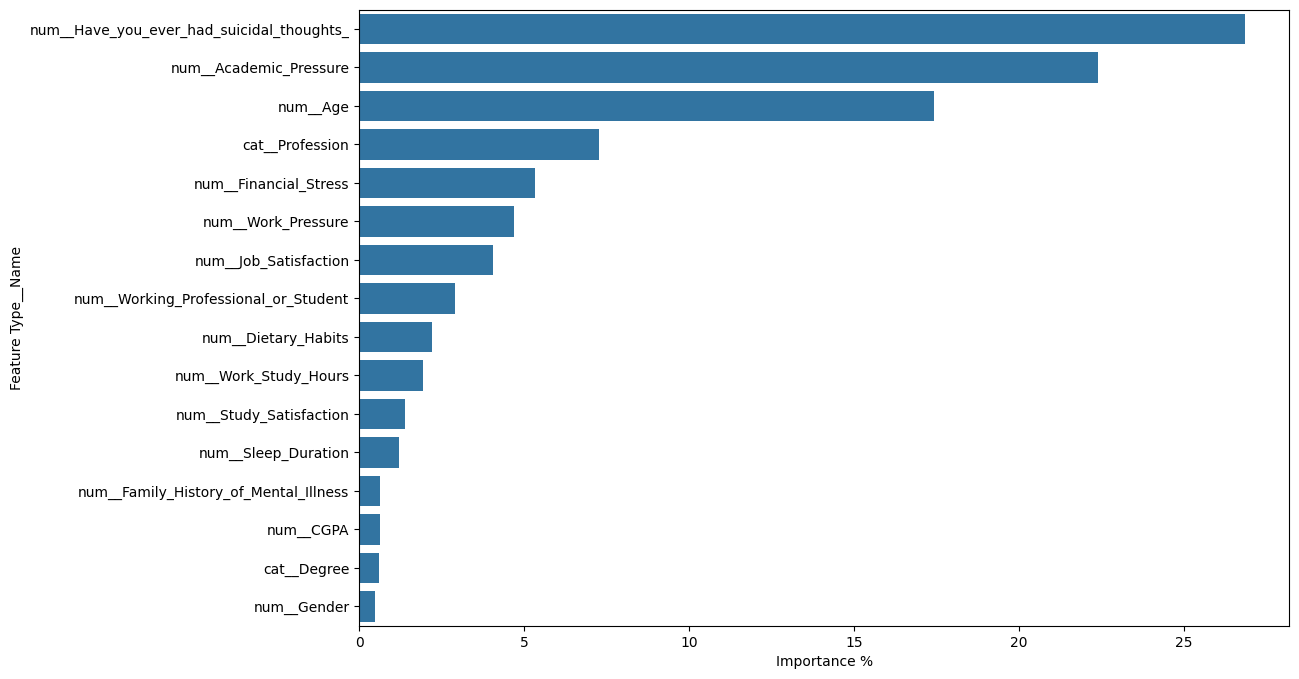

In [17]:
trainer.show_feature_importance(X)

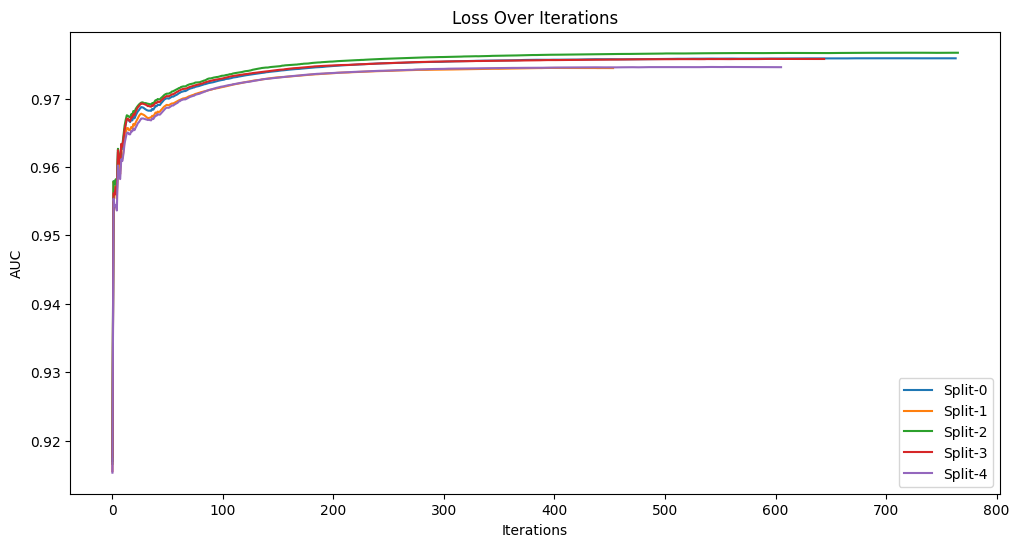

In [18]:
trainer.show_loss()

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Train complete model on all data</p>

In [19]:
complete_model = trainer.train_model(X, y, iterations=iterations, params=optimized_params)

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Make predictions on the competition data, and generate submission</p>

In [20]:
# Load the data
test_data_path = '/kaggle/input/playground-series-s4e11/test.csv'
test_data = pd.read_csv(test_data_path, index_col='id')

# standardize column names
test_data = test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))


# preprocess data
preprocess_data(test_data)
# apply pipeline
processed_test_data = pipeline.transform(test_data)

# make predictions which we will submit. 
test_preds = complete_model.predict(processed_test_data)

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'id': test_data.index,
                       'Depression': test_preds})
print(output.head(10))
output.to_csv('submission.csv', index=False)

       id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0
5  140705           0
6  140706           0
7  140707           0
8  140708           0
9  140709           1
